In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kerastuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
# Read the dataset
df = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')

In [4]:
df.head(3)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1


In [5]:
df.isnull().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
# Scale the features
scaler = StandardScaler()
X = df.drop(columns=['DEATH_EVENT'])
y = df['DEATH_EVENT']
X = scaler.fit_transform(X)

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('Num_Layers', min_value=1, max_value=12)):
        model.add(
            layers.Dense(
                units=hp.Int('Neuron_' + str(i), min_value=8, max_value=32, step=6),
                activation=hp.Choice('Activation_' + str(i), values=['relu', 'tanh', 'sigmoid']),
                input_dim=12 if i == 0 else None
            )
        )
    
    # Add the last layer of the neural network
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=hp.Choice('optimizer', values=['rmsprop', 'adam', 'nadam', 'adadelta']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

**The code defines a function to build a sequential neural network model with variable number of layers, variable number of neurons per layer, and variable activation functions, and compiles the model with a choice of optimizer, binary crossentropy loss, and accuracy metric.**

In [10]:
# Create the tuner object
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='Full_One',
    project_name='Accu'
)


In [11]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.5888888835906982

Best val_accuracy So Far: 0.7111111283302307
Total elapsed time: 00h 00m 33s


In [12]:
# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0].values

In [13]:
# Build the model with the best hyperparameters
model = tuner.get_best_models(num_models=1)[0]


In [14]:
# Define the early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [15]:
# Train the model
hist = model.fit(
    X_train, y_train,
    epochs=2000,
    initial_epoch=11,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)


Epoch 12/2000
7/7 [==============================] - 2s 38ms/step - loss: 0.6276 - accuracy: 0.7990 - val_loss: 0.6428 - val_accuracy: 0.7000
Epoch 13/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.6102 - accuracy: 0.7799 - val_loss: 0.6350 - val_accuracy: 0.6556
Epoch 14/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.5924 - accuracy: 0.7560 - val_loss: 0.6279 - val_accuracy: 0.6333
Epoch 15/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.5758 - accuracy: 0.7512 - val_loss: 0.6213 - val_accuracy: 0.6333
Epoch 16/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.5594 - accuracy: 0.7560 - val_loss: 0.6144 - val_accuracy: 0.6333
Epoch 17/2000
7/7 [==============================] - 0s 8ms/step - loss: 0.5439 - accuracy: 0.7560 - val_loss: 0.6081 - val_accuracy: 0.6444
Epoch 18/2000
7/7 [==============================] - 0s 7ms/step - loss: 0.5292 - accuracy: 0.7560 - val_loss: 0.6024 - val_accuracy: 0.6444
Epoch 19/200

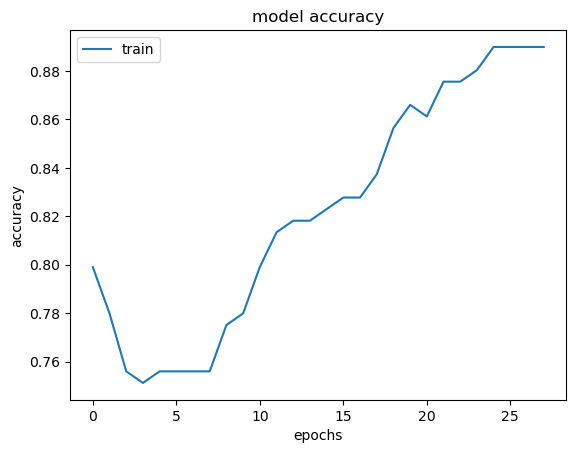

In [16]:
plt.plot(hist.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'],loc='upper left')
plt.show()